<a href="https://colab.research.google.com/github/DiploDatos/AprendizajeProfundo/blob/master/4_mlflow_experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MLflow y un experimento sencillo

## Registro de experimentos con MLflow

A la hora de trabajar con problemas de aprendizaje supervisado en general, y de aprendizaje profundo en particular, es necesario llevar un buen registro de los experimentos realizados. En particular, cuando se hace uso de algún tipo de optimización de hiperparámetros (ya sea búsqueda exhaustiva, búsqueda aleatoria o algo más complejo como optimización bayesiana), es crucial tener registro de que se fue haciendo para tomar las decisiones.

[MLflow](https://mlflow.org/) es una plataforma de código abierto que facilita mucho lleva y cuenta de los experimentos que se están realizando. Se pueden ejecutar experimentos y guardar hiperparámetros y métricas de los mismos.

A continuación vamos a ver un ejemplo muy sencillo de como realizar un experimento utilizando MLflow y el conjunto de datos de IMDB.

### Librerías

In [1]:
import gzip
import mlflow
import pandas as pd
import tempfile
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

from gensim import corpora
from gensim.parsing import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import average_precision_score
from sklearn.metrics import balanced_accuracy_score
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm, trange

import json
#import nltk
#from nltk.corpus import stopwords
#from nltk.tokenize import word_tokenize
import bz2

tqdm.pandas()


## Dataset

Nos basaremos en el dataset que creamos para el [notebook 2](https://github.com/DiploDatos/AprendizajeProfundo/blob/master/3_datasets.ipynb), con la diferencia de que pasaremos el dataframe de manera directa (esto es para poder hacer split en train/test).

Recordemos de la [notebook 2](https://github.com/DiploDatos/AprendizajeProfundo/blob/master/3_datasets.ipynb) que la clase abstracta `torch.utils.data.Dataset `es la [clase base](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html?highlight=dataset) para construir un dataset de `PyTorch`. Cualquier dataset personalizado debe heredar de dicha clase e implementar los siguientes métodos:

`__len__`: Para que el comando `len(dataset)` devuelva el tamaño del conjunto de datos.

`__getitem__`: Para soportar indexado de manera que `dataset[i]` devuelva el elemento `i`.

In [2]:
class MeliChallenge(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform
    
    def __len__(self):
        return self.dataset.shape[0]

    def __getitem__(self, item):
        if torch.is_tensor(item):
            item = item.to_list()
        
        item = {
            "data": self.dataset.loc[item, "title"],
            "target": self.dataset.loc[item, "category"]
        }
        
        if self.transform:
            item = self.transform(item)
        
        return item

## Preprocesamiento

En este caso vamos a utilizar un sólo módulo para transformar los datos de IMDB. Este se encargará de preprocesar el texto (i.e. normalizarlo) y transformará las palabras en índices de un diccionario para luego poder pasar una secuencia de palabras para buscar en la matriz de embeddings y así permitir mayor manipulación de los embeddings (en lugar de utilizar embeddings fijos).

Vamos a estar trabajando con la librería [gensim](https://pypi.org/project/gensim/) previamente importada para el procesamiento del lenguaje natural (pueden ver su código open source en este [link](https://github.com/RaRe-Technologies/gensim) ).



In [3]:
class RawDataProcessor:
    def __init__(self, 
                 dataset, 
                 ignore_header=True, 
                 filters=None, 
                 vocab_size=50000):
        if filters:
            self.filters = filters
        else:
            self.filters = [
                lambda s: s.lower(),
                preprocessing.strip_tags,
                preprocessing.strip_punctuation,
                preprocessing.strip_multiple_whitespaces,
                preprocessing.strip_numeric,
                preprocessing.remove_stopwords,
                preprocessing.strip_short,
            ]
        
        # Create dictionary based on all the reviews (with corresponding preprocessing)
        # https://radimrehurek.com/gensim/corpora/dictionary.html
        self.dictionary = corpora.Dictionary(
            dataset["title"].map(self._preprocess_string).tolist()
        )
        # Filter the dictionary with extremos words
        # https://tedboy.github.io/nlps/generated/generated/gensim.corpora.Dictionary.filter_extremes.html?highlight=filter_extrem
        self.dictionary.filter_extremes(no_below=2, no_above=1, keep_n=vocab_size)
        
        # Make the indices continuous after some words have been removed
        # https://tedboy.github.io/nlps/generated/generated/gensim.corpora.Dictionary.compactify.html
        self.dictionary.compactify()
        
        # Add a couple of special tokens
        self.dictionary.patch_with_special_tokens({
            "[PAD]": 0,
            "[UNK]": 1
        })
        self.idx_to_target = sorted(dataset["category"].unique())
        self.target_to_idx = {t: i for i, t in enumerate(self.idx_to_target)}


    def _preprocess_string(self, string):
        # https://radimrehurek.com/gensim/parsing/preprocessing.html#gensim.parsing.preprocessing.preprocess_string:~:text=gensim.parsing.preprocessing.preprocess_string
        return preprocessing.preprocess_string(string, filters=self.filters)

    def _sentence_to_indices(self, sentence):
      # https://radimrehurek.com/gensim/corpora/dictionary.html#:~:text=doc2idx(document,via%20unknown_word_index.
        return self.dictionary.doc2idx(sentence, unknown_word_index=1)
    
    def encode_data(self, data):
        return self._sentence_to_indices(self._preprocess_string(data))
    
    def encode_target(self, target):
        return self.target_to_idx[target]
    
    def __call__(self, item):
        if isinstance(item["data"], str):
            data = self.encode_data(item["data"])
        else:
            data = [self.encode_data(d) for d in item["data"]]
        
        if isinstance(item["target"], str):
            target = self.encode_target(item["target"])
        else:
            target = [self.encode_target(t) for t in item["target"]]
        
        return {
            "data": data,
            "target": target
        }

## Lectura de datos

In [4]:
train_dataset = pd.concat([x for x in pd.read_json(f"/users/galonso/data/meli-challenge-2019/spanish.train.jsonl.gz", lines=True, chunksize=100000)], ignore_index=True)
train_dataset = train_dataset[['title', 'category']]
train_dataset.head()

,title,category
0,Casita Muñecas Barbies Pintadas,DOLLHOUSES
1,Neceser Cromado Holográfico,TOILETRY_BAGS
2,Funda Asiento A Medida D20 Chevrolet,CAR_SEAT_COVERS
3,Embrague Ford Focus One 1.8 8v Td (90cv) Desde...,AUTOMOTIVE_CLUTCH_KITS
4,Bateria Panasonic Dmwbcf10 Lumix Dmc-fx60n Dmc...,CAMERA_BATTERIES


### Filtro `train_dataset` por todos los datos con las primeras 5 categorías solamente

In [5]:
cat=train_dataset['category'].head(5)

In [6]:
cat

0                DOLLHOUSES
1             TOILETRY_BAGS
2           CAR_SEAT_COVERS
3    AUTOMOTIVE_CLUTCH_KITS
4          CAMERA_BATTERIES
Name: category, dtype: object

In [7]:
train_dataset=train_dataset[train_dataset['category'].isin(list(cat))]
train_dataset.sample()

,title,category
4631903,Coverking Custom Fit Funda Para Asiento Selecc...,CAR_SEAT_COVERS


In [8]:
train_dataset.reset_index(drop=True, inplace=True)
train_dataset.tail()

,title,category
55666,Portacosméticos De Viaje Victoria's Secret *10...,TOILETRY_BAGS
55667,Set Laundry Pouch + Portacosmetico Colgante,TOILETRY_BAGS
55668,Victoria´s Secret Set 2 Portacosméticos.,TOILETRY_BAGS
55669,Beauty Case Primicia Ontario - Maxime - 6371560,TOILETRY_BAGS
55670,Bateria Original Camara Xiaomi Yi Extra Repues...,CAMERA_BATTERIES


In [9]:
preprocess_train = RawDataProcessor(train_dataset)
train_dataset = MeliChallenge(train_dataset, transform=preprocess_train)

In [10]:
len(train_dataset)

55671

In [11]:
test_dataset = pd.read_json(f"/users/galonso/data/meli-challenge-2019/spanish.test.jsonl.gz", lines=True)

In [12]:
test_dataset = test_dataset[['title', 'category']]
test_dataset.head()

,title,category
0,Mochilas Maternales Bolsos Bebe Simil Cuero Ma...,DIAPER_BAGS
1,Bolso Maternal/bebe Incluye Cambiador + Correa...,DIAPER_BAGS
2,Mochila Maternal Land + Gancho Envio Gratis-cc,DIAPER_BAGS
3,Bolso Maternal Moderno Con Cambiador Y Correa ...,DIAPER_BAGS
4,Bolso Maternal Moderno Con Cambiador Y Correa ...,DIAPER_BAGS


In [13]:
len(test_dataset)

63680

In [14]:
test_dataset=test_dataset[test_dataset['category'].isin(list(cat))]
test_dataset.sample()

,title,category
34005,Funda De Asiento Para Auto Blanca En Ecocuero,CAR_SEAT_COVERS


In [15]:
test_dataset.reset_index(drop=True, inplace=True)
test_dataset.tail()

,title,category
506,Funda Cubre Asiento Auto Cuero Ecológico Unive...,CAR_SEAT_COVERS
507,Funda Eco Cuero Premium A Medida Berlingo Par...,CAR_SEAT_COVERS
508,Funda Asiento Auto Regal Importada Acolchada ...,CAR_SEAT_COVERS
509,Funda Cubre Asiento Cuerina Cuero Auto Vw Gol ...,CAR_SEAT_COVERS
510,Funda Asiento Tela Volkswagen Fox Suran Amarok...,CAR_SEAT_COVERS


In [16]:
preprocess_test = RawDataProcessor(test_dataset)
test_dataset = MeliChallenge(test_dataset, transform=preprocess_test)

## Collation function

Como en este caso trabajamos con secuencias de palabras (representadas por sus índices en un vocabulario), cuando queremos buscar un *batch* de datos, el `DataLoader` de PyTorch espera que los datos del *batch* tengan la misma dimensión (para poder llevarlos todos a un tensor de dimensión fija). Esto lo podemos lograr mediante el parámetro de `collate_fn`. En particular, esta función se encarga de tomar varios elementos de un `Dataset` y combinarlos de manera que puedan ser devueltos como un tensor de PyTorch. Muchas veces la `collate_fn` que viene por defecto en `DataLoader` sirve (como se vio en el notebook 2), pero este no es el caso. Se define un módulo `PadSequences` que toma un valor mínimo, opcionalmente un valor máximo y un valor de relleno (*pad*) y dada una lista de secuencias, devuelve un tensor con *padding* sobre dichas secuencias.

In [17]:
class PadSequences:
    def __init__(self, pad_value=0, max_length=None, min_length=1):
        assert max_length is None or min_length <= max_length
        self.pad_value = pad_value
        self.max_length = max_length
        self.min_length = min_length

    def __call__(self, items):
        data, target = list(zip(*[(item["data"], item["target"]) for item in items]))
        seq_lengths = [len(d) for d in data]

        if self.max_length:
            max_length = self.max_length
            seq_lengths = [min(self.max_length, l) for l in seq_lengths]
        else:
            max_length = max(self.min_length, max(seq_lengths))

        data = [d[:l] + [self.pad_value] * (max_length - l)
                for d, l in zip(data, seq_lengths)]
            
        return {
            "data": torch.LongTensor(data),
            "target": torch.FloatTensor(target)
        }

## DataLoaders

Ya habiendo definido nuestros conjuntos de datos y nuestra `collation_fn`, podemos definir nuestros `DataLoader`, uno para entrenamiento y otro para evaluación. Ver que la diferencia fundamental está en `shuffle`, no queremos mezclar los valores de evaluación cada vez que evaluamos porque al evaluar mediante *mini-batchs* nos puede generar inconsistencias.

In [18]:
pad_sequences = PadSequences()
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True,
                          collate_fn=pad_sequences, drop_last=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False,
                         collate_fn=pad_sequences, drop_last=False)

In [19]:
#dataiter = iter(test_loader)
#dataiter.next()['data'][0]
                

## El modelo de clasificación

Para clasificación utilizaremos un perceptrón multicapa de dos capas ocultas. Claramente este modelo es naive y prácticamente todo lo que está *hardcodeado* (e.g. los tamaños de las capas o la cantidad de capas) podría ser parte de los parámetros del modelo. En particular, tenemos la capa de `Embeddings` que es rellenada con los valores de embeddings preentrenados (los de Glove en este caso).

Gente! Dato importante que faltó en el repo (en breve lo voy a subir)
Para los que trabajen con word embeddings, fijense que los de Glove no les van a servir, porque el MeliChallenge está en español y los embeddings en Ingles. Para esto hay dos opciones igual de válidas:

Descargar embeddings en español
Entrenar sus propios embeddings

Para la opción 1:
Descarguen el los txt de los SBW (los txt).
import bz2
with bz2.open(pretrained_embeddings_path, "rt") as fh: en su modelo, donde está lo de abrir el GZIP
`model = MyClassifier(embs_path="./data/SBW-vectors-300-min5.txt.bz2", emb_size=300)` cuando instancien los modelos. Los embeddings tienen 300 dims.

Para la opción 2:
self.embedding = nn.Embedding(vocab_size, emb_size, padding_idx)
Con vocab_size el tamaño del vocabulario del corpus del MeliChallenge, emb_size un tamaño de embedding (pueden usar 50, directamente si no quieren ajustar esto) y padding_idx=0.

In [20]:
#!curl -L https://cs.famaf.unc.edu.ar/~ccardellino/SBWCE/SBW-vectors-300-min5.txt.bz2 -O

In [21]:
class MeliClassifier(nn.Module):
    def __init__(self, 
                 pretrained_embeddings_path, 
                 dictionary,
                 vector_size,
                 freeze_embedings):
        super().__init__()
        embeddings_matrix = torch.randn(len(dictionary), vector_size)
        embeddings_matrix[0] = torch.zeros(vector_size)
        with bz2.open(pretrained_embeddings_path, "rt") as fh:
            for line in fh:
                word, vector = line.strip().split(None, 1)
                if word in dictionary.token2id:
                    embeddings_matrix[dictionary.token2id[word]] =\
                        torch.FloatTensor([float(n) for n in vector.split()])
        self.embeddings = nn.Embedding.from_pretrained(embeddings_matrix,
                                                       freeze=freeze_embedings,
                                                       padding_idx=0)
        self.hidden1 = nn.Linear(vector_size, 512)
        self.hidden2 = nn.Linear(512, 256)
        self.hidden3 = nn.Linear(256, 128)
        self.hidden4 = nn.Linear(128, 64)
        self.output = nn.Linear(64, 5)              #632 clases de salida.
        #self.output_layer = nn.Linear(128, 632)              #632 clases de salida.
        self.vector_size = vector_size
    
    def forward(self, x):
        x = self.embeddings(x)
        x = torch.mean(x, dim=1)
        x = F.relu(self.hidden1(x))
        x = F.relu(self.hidden2(x))
        x = F.relu(self.hidden3(x))
        x = F.relu(self.hidden4(x))
        x = self.output(x)  # Output Layer
        x = F.softmax(x, dim=1)
        #x = torch.sigmoid(self.output(x))
        #x = torch.nn.Softmax(self.output(x))
        return x

## Experimento de MLflow

Por último, ya tenemos todos los bloques para construir nuestro experimento de MLflow. Anotamos un par de parámetros  (estos pueden ser todos los que se consideren necesarios) y lanzamos a correr nuestro experimento. Cada vez que finaliza un epoch guardamos algunas métricas. Al finalizar todos los epochs corremos algunas métricas extras de evaluación y guardamos algunos datos extra que nos servirán para calcular otras métricas a futuro.

Material auxiliar:

-  [notebook](https://github.com/PiConsulting/Pensadero/blob/master/Eventos/2020/2020-03-06_wids_mlflow/mlflow_basic.ipynb) con un ejemplo clásico usando sklearn.


In [23]:
torch.cuda.is_available()

True

In [37]:
mlflow.set_experiment("a_NaiveMeliChallenge_experiment_Only5Cat")
EPOCHS=250
with mlflow.start_run():
    mlflow.log_param("model_name", "mlp2_only5Cat")
    mlflow.log_param("freeze_embedding", True)
    mlflow.log_params({
        "embedding_size": 300,
        "hidden1_size": 512,
        "hidden2_size": 256,
        "hidden3_size": 128,
        "hidden4_size": 64,
        "Epochs": EPOCHS,
        "optimizer": "optim.SGD_lr=0.01_momentum=0.9",
    })
    model = MeliClassifier("./SBW-vectors-300-min5.txt.bz2", preprocess_train.dictionary, 300, True) # acá reemplazar con
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    loss = nn.CrossEntropyLoss() #nn.BCELoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)#optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
    for epoch in trange(EPOCHS):
        model.train()
        running_loss = []
        targets = []
        predictions = []
        for idx, batch in enumerate(tqdm(train_loader)):
            optimizer.zero_grad()
            output = model(batch["data"].cuda())
            loss_value = loss(output, batch["target"].cuda().squeeze().long()) #.view(-1, 1))
            loss_value.backward()
            optimizer.step()
            running_loss.append(loss_value.item())        
            targets.extend(batch["target"].numpy())
            predictions.extend(torch.argmax(output.cpu(), 1).numpy())
        mlflow.log_metric("train_loss", sum(running_loss) / len(running_loss), epoch)
        mlflow.log_metric("train_bas", balanced_accuracy_score(targets, predictions), epoch)
        model.eval()
        running_loss = []
        targets = []
        predictions = []
        for batch in tqdm(test_loader):
            output = model(batch["data"].cuda())
            running_loss.append(
                loss(output, batch["target"].cuda().squeeze().long()).item() #.view(-1, 1)).item()
            )
            targets.extend(batch["target"].numpy())
            predictions.extend(torch.argmax(output.cpu(), 1).numpy())
        mlflow.log_metric("test_loss", sum(running_loss) / len(running_loss), epoch)
        #mlflow.log_metric("test_avp", average_precision_score(targets, predictions), epoch)
        mlflow.log_metric("test_bas", balanced_accuracy_score(targets, predictions), epoch)
    
    with tempfile.TemporaryDirectory() as tmpdirname:
        targets = []
        predictions = []
        for batch in tqdm(test_loader):
            output = model(batch["data"].cuda())
            targets.extend(batch["target"].cpu().numpy())
            predictions.extend(output.cpu().squeeze().detach().numpy())
        pd.DataFrame({"prediction": predictions, "target": targets}).to_csv(
            f"{tmpdirname}/predictions.csv.gz", index=False
        )
        mlflow.log_artifact(f"{tmpdirname}/predictions.csv.gz")

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

In [33]:
from sklearn.metrics import classification_report
y_true = []
y_pred = []
with torch.no_grad():
    for data in tqdm(test_loader):
        inputs, labels = data
        outputs = model(data['data'].cuda())
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(data['target'].numpy())
        y_pred.extend(predicted.cpu().numpy())
        
#print ('y_true: ', y_true)
#print ('y_pred: ', y_pred)
#print ('y_true: ', y_true)
print(classification_report(y_true, y_pred, target_names=cat))

  0%|          | 0/4 [00:00<?, ?it/s]

                        precision    recall  f1-score   support

            DOLLHOUSES       0.17      0.10      0.12       101
         TOILETRY_BAGS       0.28      0.54      0.36       102
       CAR_SEAT_COVERS       0.26      0.16      0.20       100
AUTOMOTIVE_CLUTCH_KITS       0.00      0.00      0.00       100
      CAMERA_BATTERIES       0.20      0.35      0.26       108

              accuracy                           0.23       511
             macro avg       0.18      0.23      0.19       511
          weighted avg       0.18      0.23      0.19       511



/users/galonso/miniconda3/envs/deeplearning/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/users/galonso/miniconda3/envs/deeplearning/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/users/galonso/miniconda3/envs/deeplearning/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

[[10 43  9  0 39]
 [ 5 55 13  0 29]
 [ 1 22 16  0 61]
 [17 54  7  0 22]
 [27 26 17  0 38]]


/tmp/ipykernel_3114828/1312277321.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(cat, rotation=90)
/tmp/ipykernel_3114828/1312277321.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(cat)


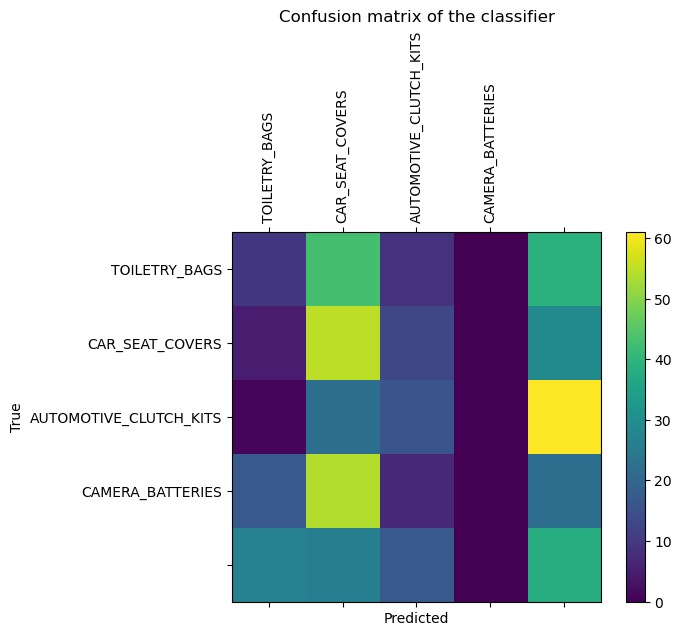

In [34]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt  
#labels = ['business', 'health']
cm = confusion_matrix(y_true, y_pred)
print(cm)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels(cat, rotation=90)
ax.set_yticklabels(cat)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [26]:
cat

0                DOLLHOUSES
1             TOILETRY_BAGS
2           CAR_SEAT_COVERS
3    AUTOMOTIVE_CLUTCH_KITS
4          CAMERA_BATTERIES
Name: category, dtype: object

In [35]:
from sklearn.metrics import classification_report
y_true = []
y_pred = []
with torch.no_grad():
    for data in tqdm(train_loader):
        inputs, labels = data
        outputs = model(data['data'].cuda())
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(data['target'].numpy())
        y_pred.extend(predicted.cpu().numpy())
        
#print ('y_true: ', y_true)
#print ('y_pred: ', y_pred)
#print ('y_true: ', y_true)
print(classification_report(y_true, y_pred, target_names=cat))

  0%|          | 0/435 [00:00<?, ?it/s]

                        precision    recall  f1-score   support

            DOLLHOUSES       0.95      0.98      0.97     13484
         TOILETRY_BAGS       0.87      0.97      0.92     11704
       CAR_SEAT_COVERS       0.84      0.96      0.89     12178
AUTOMOTIVE_CLUTCH_KITS       0.00      0.00      0.00      7171
      CAMERA_BATTERIES       0.72      0.97      0.83     11134

              accuracy                           0.84     55671
             macro avg       0.68      0.77      0.72     55671
          weighted avg       0.74      0.84      0.79     55671



/users/galonso/miniconda3/envs/deeplearning/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/users/galonso/miniconda3/envs/deeplearning/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/users/galonso/miniconda3/envs/deeplearning/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

[[13163   157    63     0   101]
 [  127 11339    55     0   183]
 [   46   119 11661     0   352]
 [  400  1166  2091     0  3514]
 [   59   220    85     0 10770]]


/tmp/ipykernel_3114828/1312277321.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(cat, rotation=90)
/tmp/ipykernel_3114828/1312277321.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(cat)


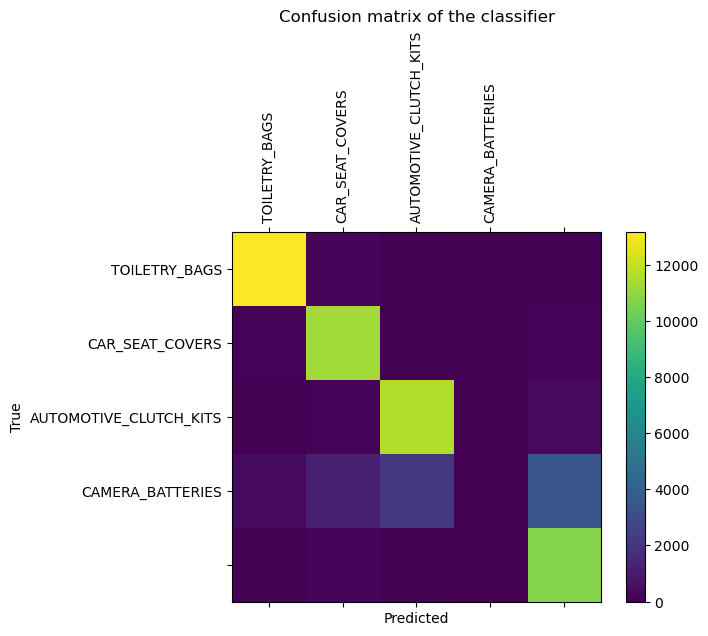

In [36]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt  
#labels = ['business', 'health']
cm = confusion_matrix(y_true, y_pred)
print(cm)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels(cat, rotation=90)
ax.set_yticklabels(cat)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [30]:
mlflow.set_experiment("a_NaiveMeliChallenge_experiment_Only5Cat")
EPOCHS=150
with mlflow.start_run():
    mlflow.log_param("model_name", "mlp1_only5Cat")
    mlflow.log_param("freeze_embedding", True)
    mlflow.log_params({
        "embedding_size": 300,
        "hidden1_size": 128,
        "hidden2_size": 64,
        "Epochs": EPOCHS,
        "optimizer": "optim.SGD_lr=0.001_momentum=0.9",
    })
    model = MeliClassifier("./SBW-vectors-300-min5.txt.bz2", preprocess_train.dictionary, 300, True) # acá reemplazar con
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    loss = nn.CrossEntropyLoss() #nn.BCELoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)#optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
    for epoch in trange(EPOCHS):
        model.train()
        running_loss = []
        targets = []
        predictions = []
        for idx, batch in enumerate(tqdm(train_loader)):
            optimizer.zero_grad()
            output = model(batch["data"].cuda())
            loss_value = loss(output, batch["target"].cuda().squeeze().long()) #.view(-1, 1))
            loss_value.backward()
            optimizer.step()
            running_loss.append(loss_value.item())        
            targets.extend(batch["target"].numpy())
            predictions.extend(torch.argmax(output.cpu(), 1).numpy())
        mlflow.log_metric("train_loss", sum(running_loss) / len(running_loss), epoch)
        mlflow.log_metric("train_bas", balanced_accuracy_score(targets, predictions), epoch)
        model.eval()
        running_loss = []
        targets = []
        predictions = []
        for batch in tqdm(test_loader):
            output = model(batch["data"].cuda())
            running_loss.append(
                loss(output, batch["target"].cuda().squeeze().long()).item() #.view(-1, 1)).item()
            )
            targets.extend(batch["target"].numpy())
            predictions.extend(torch.argmax(output.cpu(), 1).numpy())
        mlflow.log_metric("test_loss", sum(running_loss) / len(running_loss), epoch)
        #mlflow.log_metric("test_avp", average_precision_score(targets, predictions), epoch)
        mlflow.log_metric("test_bas", balanced_accuracy_score(targets, predictions), epoch)
    
    '''with tempfile.TemporaryDirectory() as tmpdirname:
        targets = []
        predictions = []
        for batch in tqdm(test_loader):
            output = model(batch["data"].cuda())
            targets.extend(batch["target"].cpu().numpy())
            predictions.extend(output.cpu().squeeze().detach().numpy())
        pd.DataFrame({"prediction": predictions, "target": targets}).to_csv(
            f"{tmpdirname}/predictions.csv.gz", index=False
        )
        mlflow.log_artifact(f"{tmpdirname}/predictions.csv.gz")'''

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

#luego de 150 epochs

In [31]:
from sklearn.metrics import classification_report
y_true = []
y_pred = []
with torch.no_grad():
    for data in tqdm(test_loader):
        inputs, labels = data
        outputs = model(data['data'].cuda())
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(data['target'].numpy())
        y_pred.extend(predicted.cpu().numpy())
        
#print ('y_true: ', y_true)
#print ('y_pred: ', y_pred)
#print ('y_true: ', y_true)
print(classification_report(y_true, y_pred, target_names=cat))

  0%|          | 0/4 [00:00<?, ?it/s]

                        precision    recall  f1-score   support

            DOLLHOUSES       0.03      0.03      0.03       101
         TOILETRY_BAGS       0.26      0.48      0.34       102
       CAR_SEAT_COVERS       0.28      0.12      0.17       100
AUTOMOTIVE_CLUTCH_KITS       0.17      0.22      0.19       100
      CAMERA_BATTERIES       0.25      0.12      0.16       108

              accuracy                           0.19       511
             macro avg       0.20      0.19      0.18       511
          weighted avg       0.20      0.19      0.18       511



[[ 3 47  3 36 12]
 [ 5 49  6 32 10]
 [53 18 12  6 11]
 [13 48 11 22  6]
 [26 26 11 32 13]]


/tmp/ipykernel_3618905/1312277321.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(cat, rotation=90)
/tmp/ipykernel_3618905/1312277321.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(cat)


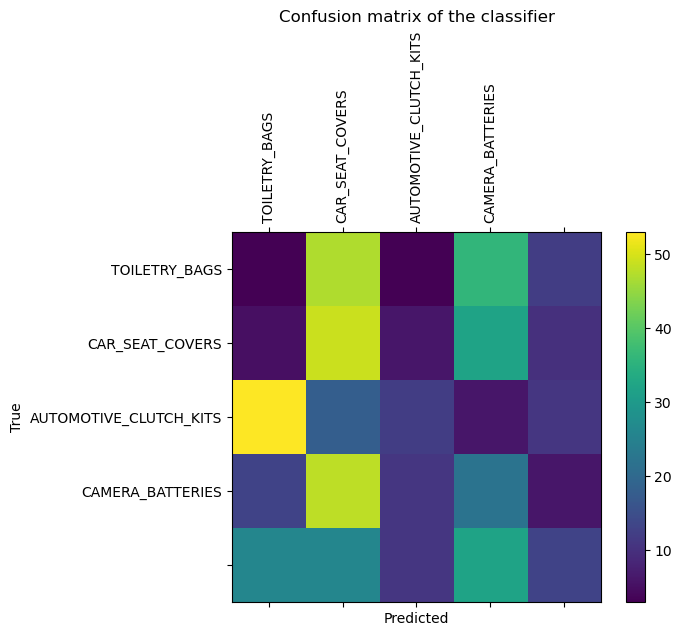

In [33]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt  
#labels = ['business', 'health']
cm = confusion_matrix(y_true, y_pred)
print(cm)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels(cat, rotation=90)
ax.set_yticklabels(cat)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()